In [1]:
!pwd

/Users/winter_camp/Documents/London/PhD/ECS742/Final/src


In [1]:
from benchmark_VAE.src.pythae.models import VQVAE, VQVAEConfig
from benchmark_VAE.src.pythae.trainers import BaseTrainerConfig
from benchmark_VAE.src.pythae.pipelines.training import TrainingPipeline
from benchmark_VAE.src.pythae.models.nn.benchmarks.sketches64.resnets import Encoder_ResNet_VQVAE_MNIST, Decoder_ResNet_VQVAE_MNIST

import torch
import torchvision.datasets as datasets

device = "cuda" if torch.cuda.is_available() else "cpu"


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms.functional import to_pil_image

In [3]:
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_epochs=10, # Change this to train the model a bit more
)


model_config = VQVAEConfig(
    latent_dim=32,
    input_dim=(1, 64, 64),
    commitment_loss_factor=0.25,
    quantization_loss_factor=1.0,
    num_embeddings=128,
    use_ema=True,
    decay=0.99
)

model = VQVAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VQVAE_MNIST(model_config), 
    decoder=Decoder_ResNet_VQVAE_MNIST(model_config) 
)

In [4]:
model

VQVAE(
  (decoder): Decoder_ResNet_VQVAE_MNIST(
    (layers): ModuleList(
      (0): ConvTranspose2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 

In [10]:
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-50000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [7]:
train_dataset[:1].shape

torch.Size([1, 1, 28, 28])

In [49]:
embedding = model.encoder(train_dataset[:1]).embedding
embedding.shape

torch.Size([1, 16, 4, 4])

In [50]:
embeddings = embedding.permute(0, 2, 3, 1)
embeddings.shape

torch.Size([1, 4, 4, 16])

In [53]:
z = model.quantizer(embeddings, uses_ddp=False).quantized_vector

In [20]:
img = torch.nn.functional.interpolate(train_dataset[2:5], size=(64,64))
img.shape

torch.Size([3, 1, 64, 64])

In [21]:
%%time
out = model(dict(data=img))

CPU times: user 16.1 ms, sys: 2.85 ms, total: 18.9 ms
Wall time: 17.1 ms


In [22]:
out.keys()

odict_keys(['recon_loss', 'vq_loss', 'loss', 'recon_x', 'z', 'quantized_indices'])

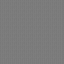

In [23]:
to_pil_image(out.recon_x[0])

In [7]:
model.decoder

Decoder_ResNet_VQVAE_MNIST(
  (layers): ModuleList(
    (0): ConvTranspose2d(16, 128, kernel_size=(1, 1), stride=(1, 1))
    (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (2): Sequential(
      (0): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): ReLU()
    )
    (4): Sequential(
      (0): ConvTranspose2d(64, 1, kernel_s

In [58]:
import torch.nn as nn

In [83]:
a = nn.ConvTranspose2d(1, 1, 3, 2, padding=1)

In [84]:
a = nn.Conv2d(1,1,3,2,padding=1)

In [85]:
b = torch.ones((3,1,28,28))

In [86]:
c = a(b)

In [87]:
c.shape

torch.Size([3, 1, 14, 14])

In [68]:
d = nn.ConvTranspose2d(1, 1, 3, 2, padding=1, output_padding=(1,1))

In [69]:
e = d(c)
e.shape

torch.Size([3, 1, 14, 14])